In [2]:
## The Baseline Method only use simple gait parameter feature, it only includes 2 dense layers
import scipy.io
import numpy as np
import random

## We delete people's data with low feedback score and remove people who kicked off the sensors during walking'
## So 20 people in total.
person_nums = [1,2,4,5,6,8,9,10,11,12,13,17,19,21,22,25,26,27,28,29]

from feature_emotion import feature_extract, split_data, label_unique_tuples
gts, sensor_nums, walk_nums, trace_nums, people_nums, spe_centr, delta_spe_centr, spe_crest, delta_spe_crest, spe_decrease, delta_spe_decrease, spe_entropy, delta_spe_entropy, spe_flatness, delta_spe_flatness, spe_flux, delta_spe_flux, spe_kurtosis, delta_spe_kurtosis, spe_skewness, delta_spe_skewness, spe_rfp, delta_spe_rfp, spe_slope, delta_spe_slope, spe_spread, delta_spe_spread, wlk_fre, wlk_fres_trace, cwt_figs_all, cwt_sum_all_0, cwt_sum_all_1, cwt_sum_all_2, cwt_sum_all_3, high_fre_compos, pitchs, low_fre_compos, auto_corrs, real_hils, imag_hils, dur_time_1_alls, dur_time_2_alls, jitters, shimmers, jitter_rap, hrs, feature, slope, zcrs, fft_features, energy_alls, log_energy_alls, smoothe_energy_alls, legendres, double_support_time, pdps_new, lpcs, ceps_features = feature_extract(person_nums)

walk_nums_all = np.squeeze(walk_nums)
trace_nums_all = np.squeeze(trace_nums)
people_nums_all = np.squeeze(people_nums)

## 0: train, 1: validation 2: test
flag_tr_val_te = split_data(walk_nums_all, trace_nums_all, people_nums_all)

In [3]:
## Data Normalization before training ans testing
import tensorflow as tf
tf.compat.v1.disable_v2_behavior()
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, concatenate, LSTM
from sklearn.preprocessing import StandardScaler
scalers = []
X_train_normalized = []
X_val_normalized = []
X_test_normalized = []
train_idx = np.where(flag_tr_val_te ==0)[0]
np.random.shuffle(train_idx)
val_idx = np.where(flag_tr_val_te ==1)[0]
test_idx = np.where(flag_tr_val_te ==2)[0]

for i, feature in enumerate([fft_features]):
    scaler = StandardScaler()
    if len(feature.shape)==2:
        X_train_i = feature[train_idx,:]
        X_val_i = feature[val_idx,:]
        X_test_i = feature[test_idx,:]
        X_train_normalized_i = scaler.fit_transform(X_train_i)
        X_val_normalized_i = scaler.transform(X_val_i)
        X_test_normalized_i = scaler.transform(X_test_i)
        scalers.append(scaler)
    else:
        X_train_i = feature[train_idx,:,:]
        X_val_i = feature[val_idx,:,:]
        X_test_i = feature[test_idx,:,:]
        X_train_normalized_i = scaler.fit_transform(X_train_i.reshape(X_train_i.shape[0], -1)).reshape(X_train_i.shape)
        X_val_normalized_i = scaler.transform(X_val_i.reshape(X_val_i.shape[0], -1)).reshape(X_val_i.shape)
        X_test_normalized_i = scaler.transform(X_test_i.reshape(X_test_i.shape[0], -1)).reshape(X_test_i.shape)
        scalers.append(scaler)
    X_train_normalized.append(X_train_normalized_i)
    X_val_normalized.append(X_val_normalized_i)
    X_test_normalized.append(X_test_normalized_i)
y_train = gts[train_idx,:]
y_val = gts[val_idx,:]
y_test = gts[test_idx,:]

2023-11-06 16:53:40.926348: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/usr/lib/python3.11/site-packages/h5py/__init__.py:36: UserWarning: h5py is running against HDF5 1.14.2 when it was built against 1.14.1, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


Instructions for updating:
non-resource variables are not supported in the long term


In [4]:
def new_label_gen(old_labels):
    new_labels = np.zeros((old_labels.shape[0],))
    
    # Define classes based on conditions
    new_labels[np.logical_and(old_labels[:, 0] <= 5, old_labels[:, 1] < 5)] = 0
    new_labels[np.logical_and(old_labels[:, 0] > 5, old_labels[:, 1] < 5)] = 1
    new_labels[np.logical_and(old_labels[:, 0] <= 5, old_labels[:, 1] >= 5)] = 2
    new_labels[np.logical_and(old_labels[:, 0] > 5, old_labels[:, 1] >= 5)] = 3
    
    # If you need one-hot encoded labels for the classification output
    one_hot_new_labels = np.eye(4)[new_labels.astype(int)]
    return one_hot_new_labels
y_train_class = new_label_gen(y_train)
y_val_class = new_label_gen(y_val)
y_test_class = new_label_gen(y_test)

In [5]:
X_train_normalized_new = []
combined_feature = np.empty((len(X_train_normalized[0]),0))
for feature in X_train_normalized:
    if len(feature.shape) == 3:
        X_train_normalized_new.append(feature)
    elif feature.shape[1] <20:
        combined_feature = np.hstack((combined_feature, feature))
    else:
        X_train_normalized_new.append(feature)
X_train_normalized_new.append(combined_feature)

X_val_normalized_new = []
combined_feature = np.empty((len(X_val_normalized[0]),0))
for feature in X_val_normalized:
    if len(feature.shape) == 3:
        X_val_normalized_new.append(feature)
    elif feature.shape[1] <20:
        combined_feature = np.hstack((combined_feature, feature))
    else:
        X_val_normalized_new.append(feature)
X_val_normalized_new.append(combined_feature)

X_test_normalized_new = []
combined_feature = np.empty((len(X_test_normalized[0]),0))
for feature in X_test_normalized:
    if len(feature.shape) == 3:
        X_test_normalized_new.append(feature)
    elif feature.shape[1] <20:
        combined_feature = np.hstack((combined_feature, feature))
    else:
        X_test_normalized_new.append(feature)
X_test_normalized_new.append(combined_feature)

In [13]:
## Build the baseline model for emotion recognition with dropout layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, concatenate, SimpleRNN, LSTM, Conv2D, Flatten, MaxPooling2D, GRU, AveragePooling2D, Dropout, Lambda
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import StandardScaler
def baseline_model(inputdim):
    input_layer = Input(shape=(inputdim,))
    h = Dense(64, activation='relu')(input_layer)
    h = Dropout(0.2)(h)
    h = Dense(32, activation='relu')(h)
    # h = Dense(16, activation='relu')(h)
    output_layer_classification = Dense(4, activation='softmax', name='classification_output')(h)
    model = Model(inputs=input_layer, outputs=output_layer_classification)
    
    # compile the model with categorical_crossentropy loss function
    model.compile(optimizer='adam', 
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    return model

In [10]:
X_train_normalized_new = np.hstack((X_train_normalized_new[0], X_train_normalized_new[1]))
X_val_normalized_new = np.hstack((X_val_normalized_new[0], X_val_normalized_new[1]))
X_test_normalized_new = np.hstack((X_test_normalized_new[0], X_test_normalized_new[1]))

In [11]:
from sklearn.utils import class_weight
# Compute class weights
y_labels = np.argmax(y_train_class, axis=1)
class_weights = class_weight.compute_class_weight(class_weight ='balanced', classes =np.unique(y_labels), y=y_labels)
class_weight_dict = dict(enumerate(class_weights))

In [14]:
import tensorflow as tf
from tensorflow.keras.callbacks import Callback
import numpy as np



model = baseline_model(X_train_normalized_new.shape[1])

num_epochs = 100


# Gradually prune weights in dense and convolutional layers from 10% to 50% over the course of training, starting from epoch 0.
model_name = './checkpoints/Adaptive_prune_model_classify_baseline.h5'

checkpoint = ModelCheckpoint(model_name, monitor='val_loss', mode='min', save_best_only=True, verbose=1)

model.fit(x=X_train_normalized_new, y=y_train_class, class_weight=class_weight_dict, epochs=num_epochs, batch_size=1024, validation_data=(X_val_normalized_new, y_val_class), callbacks=[checkpoint])



Train on 29601 samples, validate on 3694 samples


2023-11-06 16:55:08.704268: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-06 16:55:08.715360: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-06 16:55:08.715597: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Epoch 1/100


2023-11-06 16:55:08.904373: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


 1024/29601 [>.............................] - ETA: 2s - loss: 1.4700 - acc: 0.2471
Epoch 1: val_loss improved from inf to 1.32586, saving model to ./checkpoints/Adaptive_prune_model_classify_baseline.h5
29601/29601 [==============================] - 0s 7us/sample - loss: 1.3800 - acc: 0.3282 - val_loss: 1.3259 - val_acc: 0.3763
Epoch 2/100
 1024/29601 [>.............................] - ETA: 0s - loss: 1.3306 - acc: 0.3633
Epoch 2: val_loss improved from 1.32586 to 1.29335, saving model to ./checkpoints/Adaptive_prune_model_classify_baseline.h5


/usr/lib/python3.11/site-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


29601/29601 [==============================] - 0s 2us/sample - loss: 1.3117 - acc: 0.3783 - val_loss: 1.2934 - val_acc: 0.3933
Epoch 3/100
 1024/29601 [>.............................] - ETA: 0s - loss: 1.3058 - acc: 0.3838
Epoch 3: val_loss improved from 1.29335 to 1.27786, saving model to ./checkpoints/Adaptive_prune_model_classify_baseline.h5
29601/29601 [==============================] - 0s 2us/sample - loss: 1.2891 - acc: 0.3977 - val_loss: 1.2779 - val_acc: 0.4044
Epoch 4/100
 1024/29601 [>.............................] - ETA: 0s - loss: 1.2883 - acc: 0.3906
Epoch 4: val_loss improved from 1.27786 to 1.27135, saving model to ./checkpoints/Adaptive_prune_model_classify_baseline.h5
29601/29601 [==============================] - 0s 2us/sample - loss: 1.2739 - acc: 0.4078 - val_loss: 1.2713 - val_acc: 0.4058
Epoch 5/100
 1024/29601 [>.............................] - ETA: 0s - loss: 1.2548 - acc: 0.4053
Epoch 5: val_loss improved from 1.27135 to 1.26034, saving model to ./checkpoints/A

In [15]:
import tensorflow as tf
from tensorflow.keras.callbacks import Callback
import numpy as np



model = baseline_model(X_train_normalized_new.shape[1])

num_epochs = 100


# Gradually prune weights in dense and convolutional layers from 10% to 50% over the course of training, starting from epoch 0.
model_name = './checkpoints/Adaptive_prune_model_classify_baseline_nobalance.h5'

checkpoint = ModelCheckpoint(model_name, monitor='val_loss', mode='min', save_best_only=True, verbose=1)

model.fit(x=X_train_normalized_new, y=y_train_class, epochs=num_epochs, batch_size=1024, validation_data=(X_val_normalized_new, y_val_class), callbacks=[checkpoint])


Train on 29601 samples, validate on 3694 samples
Epoch 1/100
 1024/29601 [>.............................] - ETA: 0s - loss: 1.5787 - acc: 0.2275
Epoch 1: val_loss improved from inf to 1.30339, saving model to ./checkpoints/Adaptive_prune_model_classify_baseline_nobalance.h5
29601/29601 [==============================] - 0s 5us/sample - loss: 1.3550 - acc: 0.3744 - val_loss: 1.3034 - val_acc: 0.4074
Epoch 2/100
 1024/29601 [>.............................] - ETA: 0s - loss: 1.2596 - acc: 0.4492

2023-11-06 16:55:45.508295: W tensorflow/c/c_api.cc:304] Operation '{name:'training_2/Adam/dense_4/bias/v/Assign' id:919 op device:{requested: '', assigned: ''} def:{{{node training_2/Adam/dense_4/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_2/Adam/dense_4/bias/v, training_2/Adam/dense_4/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-06 16:55:45.627464: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_3/mul' id:755 op device:{requested: '', assigned: ''} def:{{{node loss_3/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_3/mul/x, loss_3/classification_output_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an err


Epoch 2: val_loss improved from 1.30339 to 1.26911, saving model to ./checkpoints/Adaptive_prune_model_classify_baseline_nobalance.h5
29601/29601 [==============================] - 0s 2us/sample - loss: 1.2679 - acc: 0.4371 - val_loss: 1.2691 - val_acc: 0.4172
Epoch 3/100
 1024/29601 [>.............................] - ETA: 0s - loss: 1.2801 - acc: 0.4180
Epoch 3: val_loss improved from 1.26911 to 1.25859, saving model to ./checkpoints/Adaptive_prune_model_classify_baseline_nobalance.h5
29601/29601 [==============================] - 0s 2us/sample - loss: 1.2434 - acc: 0.4483 - val_loss: 1.2586 - val_acc: 0.4247
Epoch 4/100
 1024/29601 [>.............................] - ETA: 0s - loss: 1.2231 - acc: 0.4590
Epoch 4: val_loss improved from 1.25859 to 1.24963, saving model to ./checkpoints/Adaptive_prune_model_classify_baseline_nobalance.h5
29601/29601 [==============================] - 0s 2us/sample - loss: 1.2305 - acc: 0.4523 - val_loss: 1.2496 - val_acc: 0.4239
Epoch 5/100
 1024/29601 

In [17]:
## Evaluation on test set:
import tensorflow as tf
from feature_emotion import feature_extract, split_data, label_unique_tuples
trace_wlk_num = label_unique_tuples(people_nums_all, walk_nums_all, trace_nums_all)
trace_wlk_num = np.array(trace_wlk_num )
model = tf.keras.models.load_model("./checkpoints/Adaptive_prune_model_classify_baseline.h5")
y_pred_class = model.predict(X_test_normalized_new)
from collections import Counter

def find_mode(nums):
    count = Counter(nums)
    return count.most_common(1)[0][0]

## Evaluation: trace median vote
trace_num_test = trace_wlk_num[test_idx]
u = np.unique(trace_num_test)
pred_trace = np.empty((0, 1))
gt_trace = np.empty((0, 1))
for i in u:
  trace_idx = np.where(trace_num_test == i)[0]
  y_pred_trace = y_pred_class[trace_idx,:]
  pred_class = np.argmax(y_pred_trace, axis=1)
  pred_trace = np.vstack((pred_trace, find_mode(pred_class)))
  gt_t = y_test_class[trace_idx[0],:]
  gt_t =np.argmax(gt_t)
  gt_trace = np.vstack((gt_trace, gt_t))

from sklearn.metrics import accuracy_score, confusion_matrix


# Calculate accuracy
accuracy = accuracy_score(gt_trace, pred_trace)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Calculate confusion matrix
cm = confusion_matrix(gt_trace, pred_trace)
print('Confusion Matrix:')
print(cm)

2023-11-06 16:57:49.235099: W tensorflow/c/c_api.cc:304] Operation '{name:'classification_output_4/kernel/Assign' id:1419 op device:{requested: '', assigned: ''} def:{{{node classification_output_4/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](classification_output_4/kernel, classification_output_4/kernel/Initializer/random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-06 16:57:49.354195: W tensorflow/c/c_api.cc:304] Operation '{name:'dense_3_2/kernel/m/Assign' id:1574 op device:{requested: '', assigned: ''} def:{{{node dense_3_2/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_3_2/kernel/m, dense_3_2/kernel/m/Initializer/zeros)}}' was changed by setting attribute after 

Accuracy: 55.66%
Confusion Matrix:
[[43  4  7  5]
 [37 56 15  8]
 [11 13 47  4]
 [17 10  6 26]]


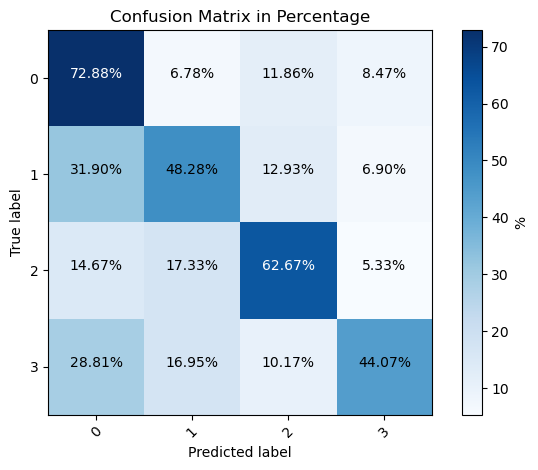

In [18]:
import matplotlib.pyplot as plt
# Normalize the matrix to get percentages
matrix = cm
normalized_matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
percentage_matrix = normalized_matrix * 100

# Plot the matrix
plt.imshow(percentage_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix in Percentage')
plt.colorbar(label='%')
tick_marks = np.arange(4)  # Adjust if you have a different number of classes
plt.xticks(tick_marks, range(4), rotation=45)
plt.yticks(tick_marks, range(4))
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Display percentages on the matrix
for i in range(percentage_matrix.shape[0]):
    for j in range(percentage_matrix.shape[1]):
        plt.text(j, i, format(percentage_matrix[i, j], '.2f') + '%',
                 horizontalalignment="center",
                 color="white" if percentage_matrix[i, j] > 50 else "black")

plt.tight_layout()
plt.show()

In [19]:
from sklearn.metrics import f1_score
f1_score(gt_trace, pred_trace, average='micro')

0.5566343042071198

In [20]:
## Evaluation on test set:
import tensorflow as tf
from feature_emotion import feature_extract, split_data, label_unique_tuples
trace_wlk_num = label_unique_tuples(people_nums_all, walk_nums_all, trace_nums_all)
trace_wlk_num = np.array(trace_wlk_num )
model = tf.keras.models.load_model("./checkpoints/Adaptive_prune_model_classify_baseline_nobalance.h5")
y_pred_class = model.predict(X_test_normalized_new)
from collections import Counter

def find_mode(nums):
    count = Counter(nums)
    return count.most_common(1)[0][0]

## Evaluation: trace median vote
trace_num_test = trace_wlk_num[test_idx]
u = np.unique(trace_num_test)
pred_trace = np.empty((0, 1))
gt_trace = np.empty((0, 1))
for i in u:
  trace_idx = np.where(trace_num_test == i)[0]
  y_pred_trace = y_pred_class[trace_idx,:]
  pred_class = np.argmax(y_pred_trace, axis=1)
  pred_trace = np.vstack((pred_trace, find_mode(pred_class)))
  gt_t = y_test_class[trace_idx[0],:]
  gt_t =np.argmax(gt_t)
  gt_trace = np.vstack((gt_trace, gt_t))

from sklearn.metrics import accuracy_score, confusion_matrix


# Calculate accuracy
accuracy = accuracy_score(gt_trace, pred_trace)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Calculate confusion matrix
cm = confusion_matrix(gt_trace, pred_trace)
print('Confusion Matrix:')
print(cm)

2023-11-06 16:58:22.184728: W tensorflow/c/c_api.cc:304] Operation '{name:'classification_output_5/kernel/Assign' id:1753 op device:{requested: '', assigned: ''} def:{{{node classification_output_5/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](classification_output_5/kernel, classification_output_5/kernel/Initializer/random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-06 16:58:22.309768: W tensorflow/c/c_api.cc:304] Operation '{name:'dense_5_1/bias/m/Assign' id:1913 op device:{requested: '', assigned: ''} def:{{{node dense_5_1/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_5_1/bias/m, dense_5_1/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was r

Accuracy: 50.49%
Confusion Matrix:
[[14 35  3  7]
 [11 95  4  6]
 [ 2 47 24  2]
 [ 3 31  2 23]]


2023-11-06 16:58:22.386017: W tensorflow/c/c_api.cc:304] Operation '{name:'classification_output_5/Softmax' id:1764 op device:{requested: '', assigned: ''} def:{{{node classification_output_5/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](classification_output_5/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


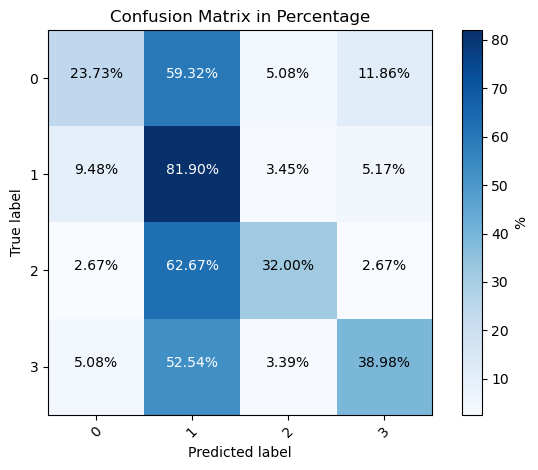

In [21]:
import matplotlib.pyplot as plt
# Normalize the matrix to get percentages
matrix = cm
normalized_matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
percentage_matrix = normalized_matrix * 100

# Plot the matrix
plt.imshow(percentage_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix in Percentage')
plt.colorbar(label='%')
tick_marks = np.arange(4)  # Adjust if you have a different number of classes
plt.xticks(tick_marks, range(4), rotation=45)
plt.yticks(tick_marks, range(4))
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Display percentages on the matrix
for i in range(percentage_matrix.shape[0]):
    for j in range(percentage_matrix.shape[1]):
        plt.text(j, i, format(percentage_matrix[i, j], '.2f') + '%',
                 horizontalalignment="center",
                 color="white" if percentage_matrix[i, j] > 50 else "black")

plt.tight_layout()
plt.show()

In [22]:
from sklearn.metrics import f1_score
f1_score(gt_trace, pred_trace, average='micro')

0.5048543689320388